In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



data = pd.read_csv("../master_dataset/processed_data.csv")

#drop unwanted features
data = data.drop(['title', 'text', 'text_without_stopwords', 'title_without_stopwords','syllables', 'polarity_category', 'overall_content', 'polarity'],axis=1)  

In [2]:
data['class'].value_counts()

0    21196
1    17462
Name: class, dtype: int64

Dataset is slightly imbalanced so we will perform under sampling  to address this after the train-test split.

In [5]:

x = data.iloc[:,1:]
y = data.iloc[:,:1]

#first split dataset into train, validation and test sets
#
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4222)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 4222)

#balance x_train with oversampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy = 'majority')
x_train,y_train = undersample.fit_resample(x_train, y_train)
data = pd.concat([x_train,y_train],axis = 1)

#check that train set is oversampled
data['class'].value_counts()

#There is no need  to perform feature scaling because ensemble methods such as XGBoost and AdaBoost are not sensitive to the variance in the data.

0    10477
1    10477
Name: class, dtype: int64

Final proportion is 60% train data, 20% validation data and 20% test data.

Baseline AdaBoost Model

In [6]:
ada_boost = AdaBoostClassifier( random_state = 4222)
ada_boost.fit(x_train, np.ravel(y_train))
y_pred_ada_boost = ada_boost.predict(x_validation)

#validation metrics
print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation, y_pred_ada_boost))
print("Precision:", metrics.precision_score(y_validation, y_pred_ada_boost))
print("Recall:",metrics.recall_score(y_validation, y_pred_ada_boost))
print("F1_score:", metrics.f1_score(y_validation, y_pred_ada_boost))
print("-------------------------------")
#test metrics
y_pred_ada_boost = ada_boost.predict(x_test)
print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_ada_boost))
print("Precision:", metrics.precision_score(y_test, y_pred_ada_boost))
print("Recall:",metrics.recall_score(y_test, y_pred_ada_boost))
print("F1_score:", metrics.f1_score(y_test, y_pred_ada_boost))

Performance on Validation set:
Accuracy: 0.9693481634764615
Precision: 0.9672319632078183
Recall: 0.9647362385321101
F1_score: 0.9659824888761304
-------------------------------
Performance on  Test set:
Accuracy: 0.9698654940506984
Precision: 0.9636363636363636
Recall: 0.9699742636545611
F1_score: 0.966794926606812


Hyperparameter Tuning with GridSearch (Adaboost)

In [8]:
grid_params = {
    'n_estimators': [50, 100, 200,500,1000],
    'learning_rate': [0.01, 0.1, 0.5, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R'],
}
scorer = metrics.make_scorer(metrics.f1_score)

gridCV = GridSearchCV(AdaBoostClassifier(random_state = 4222), param_grid = grid_params, cv = 5, scoring = scorer, n_jobs=-1)
gridCV.fit(x_train,np.ravel(y_train))
print("Best Hyper Parameters: ", gridCV.best_params_)

Best Hyper Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 1000}


We perform tuning for adaboost with cross-validation to reduce the variance in the model while searching for the best parameters. Once the parameters are found, we will fit the tuned model and perform
predictions accordingly.

Tuned Adaboost Model

In [14]:
ada_boost = AdaBoostClassifier( algorithm= 'SAMME.R', learning_rate= 0.1, n_estimators= 1000, random_state = 1)
ada_boost.fit(x_train, np.ravel(y_train))
y_pred_ada_boost = ada_boost.predict(x_validation)

#validation metrics
print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation, y_pred_ada_boost))
print("Precision:", metrics.precision_score(y_validation, y_pred_ada_boost))
print("Recall:",metrics.recall_score(y_validation, y_pred_ada_boost))
print("F1_score:", metrics.f1_score(y_validation, y_pred_ada_boost))
print("-------------------------------")
#test metrics
y_pred_ada_boost = ada_boost.predict(x_test)
print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_ada_boost))
print("Precision:", metrics.precision_score(y_test, y_pred_ada_boost))
print("Recall:",metrics.recall_score(y_test, y_pred_ada_boost))
print("F1_score:", metrics.f1_score(y_test, y_pred_ada_boost))

Performance on Validation set:
Accuracy: 0.9745214692188309
Precision: 0.9732528041415013
Recall: 0.9701834862385321
F1_score: 0.9717157214644652
-------------------------------
Performance on  Test set:
Accuracy: 0.9725814795654423
Precision: 0.9667519181585678
Recall: 0.9728338575922219
F1_score: 0.9697833523375143


Similarly, we perform the same steps for XGBoost.

Baseline XGBoost Model

In [10]:
xg_reg = xgb.XGBClassifier(objective = 'binary:logistic') 
xg_reg.fit(x_train,np.ravel(y_train))

#validation metrics
y_pred_xg = xg_reg.predict(x_validation)
#y_pred_xg = np.where(y_pred_xg > 0.5, 1, 0)

print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation, y_pred_xg))
print("Precision:", metrics.precision_score(y_validation, y_pred_xg))
print("Recall:",metrics.recall_score(y_validation, y_pred_xg))
print("F1_score:", metrics.f1_score(y_validation, y_pred_xg))
print("-------------------------------")

#test metrics
y_pred_xg = xg_reg.predict(x_test)
#y_pred_xg = np.where(y_pred_xg > 0.5, 1, 0)

print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_xg))
print("Precision:", metrics.precision_score(y_test, y_pred_xg))
print("Recall:",metrics.recall_score(y_test, y_pred_xg))
print("F1_score:", metrics.f1_score(y_test, y_pred_xg))

Performance on Validation set:
Accuracy: 0.981246766683911
Precision: 0.9832321480196589
Recall: 0.9750573394495413
F1_score: 0.979127681013387
-------------------------------
Performance on  Test set:
Accuracy: 0.9780134505949302
Precision: 0.978705035971223
Recall: 0.9725478981984558
F1_score: 0.9756167527251864


Hyperparameter tuning for XGBoost using Gridsearch

In [11]:
#hyperparameter tuning with gridsearch for XGBoost
grid_params = {
    'n_estimators': [50, 200, 300, 400],
    'learning_rate': [0.01, 0.3, 0.5, 1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'subsample': [0.6, 0.7, 0.8],
    'gamma': [0.3, 0.4, 0.5],
    'max_depth': [ 3, 6, 8],
}
scorer = metrics.make_scorer(metrics.f1_score)

gridCV = GridSearchCV(estimator = xg_reg, param_grid = grid_params, cv = 3, scoring = scorer, n_jobs=-1, verbose = 1)
gridCV.fit(x_train,np.ravel(y_train))
print("Best Hyper Parameters: ", gridCV.best_params_)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Best Hyper Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Tuned XGBoost Model

In [16]:
xg_reg = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 200, learning_rate = 0.3, colsample_bytree = 0.6, subsample = 0.8, gamma = 0.5, max_depth = 3) 
xg_reg.fit(x_train,np.ravel(y_train))

#validation metrics
y_pred_xg = xg_reg.predict(x_validation)
#y_pred_xg = np.where(y_pred_xg > 0.5, 1, 0)

print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation, y_pred_xg))
print("Precision:", metrics.precision_score(y_validation, y_pred_xg))
print("Recall:",metrics.recall_score(y_validation, y_pred_xg))
print("F1_score:", metrics.f1_score(y_validation, y_pred_xg))
print("-------------------------------")

#test metrics
y_pred_xg = xg_reg.predict(x_test)
#y_pred_xg = np.where(y_pred_xg > 0.5, 1, 0)

print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_xg))
print("Precision:", metrics.precision_score(y_test, y_pred_xg))
print("Recall:",metrics.recall_score(y_test, y_pred_xg))
print("F1_score:", metrics.f1_score(y_test, y_pred_xg))

Performance on Validation set:
Accuracy: 0.981246766683911
Precision: 0.9832321480196589
Recall: 0.9750573394495413
F1_score: 0.979127681013387
-------------------------------
Performance on  Test set:
Accuracy: 0.9793067770305225
Precision: 0.9771232484987132
Recall: 0.9771232484987132
F1_score: 0.9771232484987132


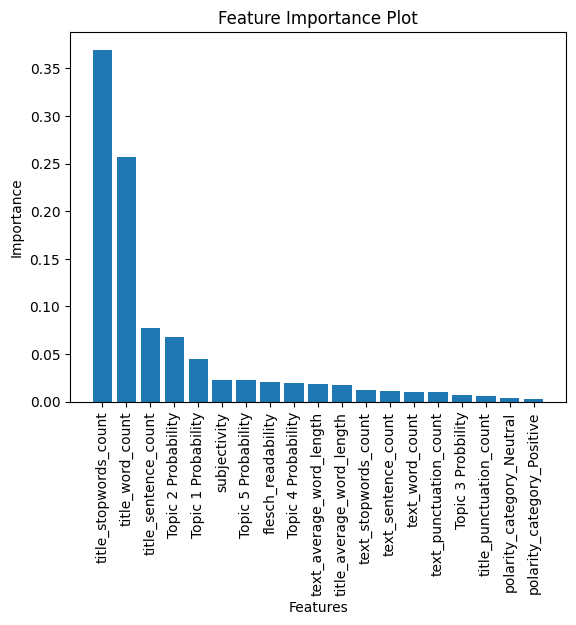

In [21]:
importances = xg_reg.feature_importances_
sort = np.argsort(importances)[::-1]

# Plot the feature importances
plt.bar(data.columns[sort], importances[sort])
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.show()